In [1]:
import sys 
from bfseg.data.fsdata import load_fsdata
import tensorflow as tf
import os
import json
import matplotlib.pyplot as plt
import cv2
import numpy as np
import sys
import tensorflow_datasets as tfds
from zipfile import ZipFile
import bfseg.models.fast_scnn
import bfseg.data.hive.office_rumlang_validation_labeled
import bfseg.data.hive.bfseg_validation_labeled
from bfseg.utils.utils import load_gdrive_file
from matplotlib import colors
#from bfseg.settings import TMPDIR
TMPDIR = "/home/matthias/data/rss_2021_data/tmp/"
MASKPATH = "/home/matthias/data/rss_2021_data/mask.png"

Segmentation Models: using `tf.keras` framework.


## Load important data

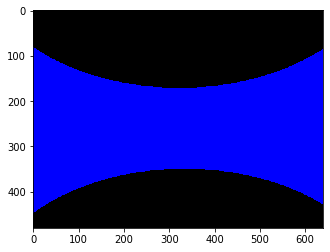

In [2]:
# Load mask
mask = plt.imread(MASKPATH)
ax = plt.subplot()
# foreground, background, unknown
cmap3 = colors.ListedColormap(['black', 'blue', 'gray'])
cmap2 = colors.ListedColormap(['black', 'blue'])
ax.imshow(mask, cmap=cmap2)
mask_filtered = np.nonzero(mask)
test = mask[mask_filtered]

In [3]:
# Test dataset:
val_ds_office_gt = tfds.load('office_rumlang_validation_labeled', split='OFFICE')

In [4]:
# NYU Depth dataset:
nyu_depth_ds = tfds.load("NyuDepthV2LabeledDepth", split="full[:1%]")

In [5]:
# Office 12 dataset:
val_ds_office_12 = tfds.load('MeshdistPseudolabelsDense', split='office12_dense20_dyn_cam2[:10%]')

In [68]:
# Office 3 dataset:
val_ds_office_3 = tfds.load('MeshdistPseudolabelsDense', split='office3_combined2050_dyn_cam2[:10%]')

## gt_segmentation_example

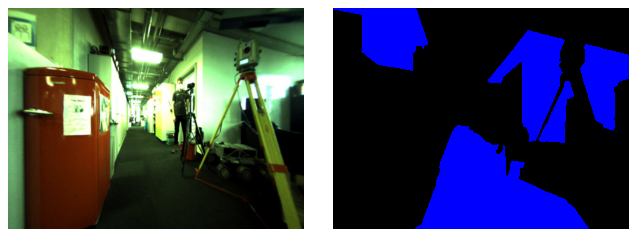

In [92]:
samples_iter = iter(val_ds_office_gt.take(10))
for i in range(3):
    entry1 = next(samples_iter)

figure0 = plt.figure(figsize=(10, 5), dpi=80)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.subplot(1,2,1)
plt.imshow(entry1['image'])
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(entry1['label'], cmap=cmap2)
plt.axis('off')

figure0.savefig("presentation_figures/gt_segmentation_example.pdf", bbox_inches='tight')
figure0.savefig("presentation_figures/gt_segmentation_example.png", bbox_inches='tight')


## dense_pseudolabels_example1 (rgb, sparse, dense, depth)

In [62]:
datapath = '/home/matthias/data/rss_2021_data/label_datasets/office3_visualization_dataset/'
if not os.path.exists(os.path.join(datapath, 'dataset_info.json')):
    with open(os.path.join(datapath, 'dataset_info.json'), 'w') as f:
        json.dump({
            'output_shapes': {'rgb': [None, None, 3], 'sparselabels': [None, None], 'denselabels': [None, None], 'combinedlabels': [None, None], 'depthlabels': [None, None], 'unaggregatedlabels': [None, None], 'sparsedepthlabels': [None, None]},
            'output_types': {'rgb': 'uint8', 'sparselabels': 'int32', 'denselabels': 'int32', 'combinedlabels': 'int32', 'depthlabels': 'int32', 'unaggregatedlabels': 'int32', 'sparsedepthlabels': 'int32'}
        }, f)
combined_demo_ds = load_fsdata(datapath)
print(combined_demo_ds)

<FlatMapDataset shapes: {rgb: (None, None, 3), sparselabels: (None, None), denselabels: (None, None), combinedlabels: (None, None), depthlabels: (None, None), unaggregatedlabels: (None, None), sparsedepthlabels: (None, None), filename: ()}, types: {rgb: tf.uint8, sparselabels: tf.int32, denselabels: tf.int32, combinedlabels: tf.int32, depthlabels: tf.int32, unaggregatedlabels: tf.int32, sparsedepthlabels: tf.int32, filename: tf.string}>


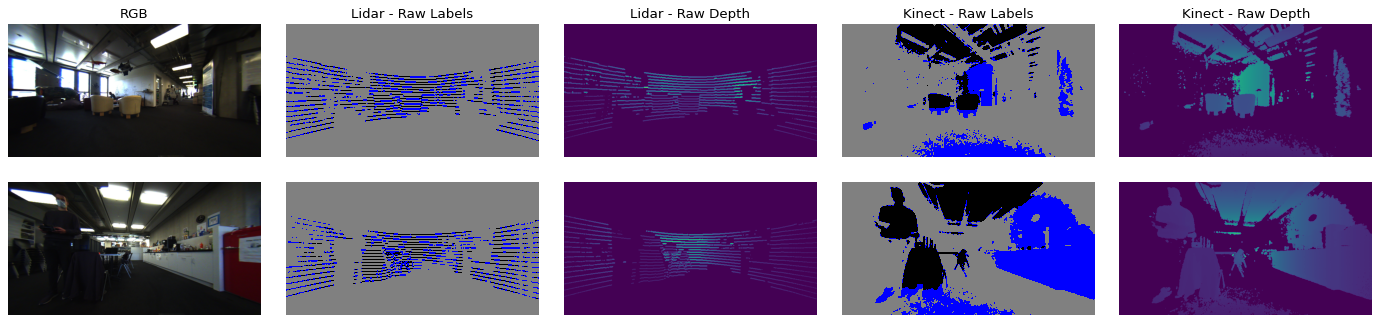

In [63]:
samples_iter1 = iter(combined_demo_ds)
samples_iter2 = iter(combined_demo_ds)
for i in range(60):
    entry1 = next(samples_iter1)
for i in range(100):
    entry2 = next(samples_iter2)
figure0 = plt.figure(figsize=(22, 5), dpi=80)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax1 = plt.subplot(2,5,1)
ax1.imshow(entry1['rgb'])
ax1.set_title('RGB')
plt.axis('off')
ax1 = plt.subplot(2,5,2)
unaggregated = np.where(tf.logical_and(entry1['unaggregatedlabels'] > 0, entry1['unaggregatedlabels'] < int(255/10*0.5)), 1, 2)
unaggregated = np.where(entry1['unaggregatedlabels'] >= int(255/10*0.5), 0, unaggregated)
ax1.imshow(unaggregated, cmap=cmap3)
ax1.set_title('Lidar - Raw Labels')
plt.axis('off')
ax1 = plt.subplot(2,5,3)
ax1.imshow(entry1['sparsedepthlabels'], vmin=0, vmax=255)
ax1.set_title('Lidar - Raw Depth')
plt.axis('off')
ax1 = plt.subplot(2,5,4)
ax1.imshow(entry1['denselabels'], cmap=cmap3)
ax1.set_title('Kinect - Raw Labels')
plt.axis('off')
ax1 = plt.subplot(2,5,5)
ax1.imshow(entry1['depthlabels'], vmin=0, vmax=255)
ax1.set_title('Kinect - Raw Depth')
plt.axis('off')

ax1 = plt.subplot(2,5,6)
ax1.imshow(entry2['rgb'])
plt.axis('off')
ax1 = plt.subplot(2,5,7)
unaggregated = np.where(tf.logical_and(entry2['unaggregatedlabels'] > 0, entry2['unaggregatedlabels'] < int(255/10*0.5)), 1, 2)
unaggregated = np.where(entry2['unaggregatedlabels'] >= int(255/10*0.5), 0, unaggregated)
ax1.imshow(unaggregated, cmap=cmap3)
plt.axis('off')
ax1 = plt.subplot(2,5,8)
ax1.imshow(entry2['sparsedepthlabels'], vmin=0, vmax=255)
plt.axis('off')
ax1 = plt.subplot(2,5,9)
ax1.imshow(entry2['denselabels'], cmap=cmap3)
plt.axis('off')
ax1 = plt.subplot(2,5,10)
ax1.imshow(entry2['depthlabels'], vmin=0, vmax=255)
plt.axis('off')

figure0.savefig("presentation_figures/dense_pseudolabels_example1.pdf", bbox_inches='tight')
figure0.savefig("presentation_figures/dense_pseudolabels_example1.png", bbox_inches='tight')

## dense_pseudolabels_example2 (rgb, sparse, dense, combined)

In [85]:
datapath = '/home/matthias/data/rss_2021_data/label_aggregator_dense/labels_lidar/'
if not os.path.exists(os.path.join(datapath, 'dataset_info.json')):
    with open(os.path.join(datapath, 'dataset_info.json'), 'w') as f:
        json.dump({
            'output_shapes': {'rgb': [None, None, 3], 'sparselabels': [None, None], 'denselabels': [None, None], 'combinedlabels': [None, None], 'depthlabels': [None, None], 'unaggregatedlabels': [None, None], 'sparsedepthlabels': [None, None]},
            'output_types': {'rgb': 'uint8', 'sparselabels': 'int32', 'denselabels': 'int32', 'combinedlabels': 'int32', 'depthlabels': 'int32', 'unaggregatedlabels': 'int32', 'sparsedepthlabels': 'int32'}
        }, f)
combined_demo_ds = load_fsdata(datapath)
print(combined_demo_ds)

<FlatMapDataset shapes: {rgb: (None, None, 3), sparselabels: (None, None), denselabels: (None, None), combinedlabels: (None, None), depthlabels: (None, None), unaggregatedlabels: (None, None), sparsedepthlabels: (None, None), filename: ()}, types: {rgb: tf.uint8, sparselabels: tf.int32, denselabels: tf.int32, combinedlabels: tf.int32, depthlabels: tf.int32, unaggregatedlabels: tf.int32, sparsedepthlabels: tf.int32, filename: tf.string}>


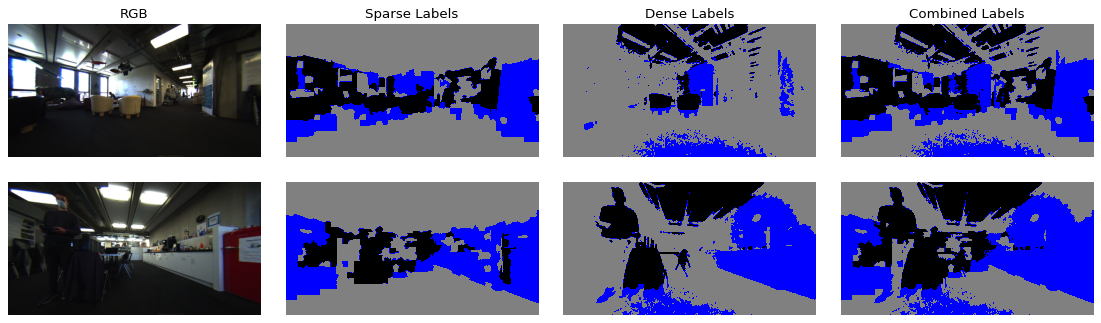

In [48]:
samples_iter1 = iter(combined_demo_ds)
samples_iter2 = iter(combined_demo_ds)
for i in range(60):
    entry1 = next(samples_iter1)
for i in range(100):
    entry2 = next(samples_iter2)
figure0 = plt.figure(figsize=(17.5, 5), dpi=80)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax1 = plt.subplot(2,4,1)
ax1.imshow(entry1['rgb'])
ax1.set_title('RGB')
plt.axis('off')
ax1 = plt.subplot(2,4,2)
ax1.imshow(entry1['sparselabels'], cmap=cmap3)
plt.axis('off')
ax1.set_title('Sparse Labels')
ax1 = plt.subplot(2,4,3)
ax1.imshow(entry1['denselabels'], cmap=cmap3)
plt.axis('off')
ax1.set_title('Dense Labels')
ax1 = plt.subplot(2,4,4)
ax1.imshow(entry1['combinedlabels'], cmap=cmap3)
plt.axis('off')
ax1.set_title('Combined Labels')

ax1 = plt.subplot(2,4,5)
ax1.imshow(entry2['rgb'])
plt.axis('off')
ax1 = plt.subplot(2,4,6)
ax1.imshow(entry2['sparselabels'], cmap=cmap3)
plt.axis('off')
ax1 = plt.subplot(2,4,7)
ax1.imshow(entry2['denselabels'], cmap=cmap3)
plt.axis('off')
ax1 = plt.subplot(2,4,8)
ax1.imshow(entry2['combinedlabels'], cmap=cmap3)
plt.axis('off')

figure0.savefig("presentation_figures/dense_pseudolabels_example2.pdf", bbox_inches='tight')
figure0.savefig("presentation_figures/dense_pseudolabels_example2.png", bbox_inches='tight')

## visual_results_fastscnn1 (rgb, pretraining, sparse, dense, combined)

In [7]:
pretraining_model = tf.keras.models.load_model('/home/matthias/data/rss_2021_data/xavier_models/office3_sparse50_dyn_cam2_finetuning_1/model_epoch_initial.h5')
sparse_model = tf.keras.models.load_model('/home/matthias/data/rss_2021_data/xavier_models/office3_sparse50_dyn_cam2_finetuning_1/model_epoch_10.h5')
dense_model = tf.keras.models.load_model('/home/matthias/data/rss_2021_data/xavier_models/office3_dense20_dyn_cam2_finetuning_1/model_epoch_5.h5')
dense_depth_model = tf.keras.models.load_model('/home/matthias/data/rss_2021_data/xavier_models/office3_densedepth20_dyn_cam2_finetuning_2/model_epoch_6.h5')
pretraining_depth_model = tf.keras.models.load_model('/home/matthias/data/rss_2021_data/xavier_models/nyu_depth_pretraining_14/model_epoch_65.h5')
combined_model = tf.keras.models.load_model('/home/matthias/data/rss_2021_data/xavier_models/office3_combined2050_dyn_cam2_finetuning_1/model_epoch_6.h5')
combined_model_overfit = tf.keras.models.load_model('/home/matthias/data/rss_2021_data/xavier_models/office3_combined2050_dyn_cam2_finetuning_1full/model_epoch_50.h5')

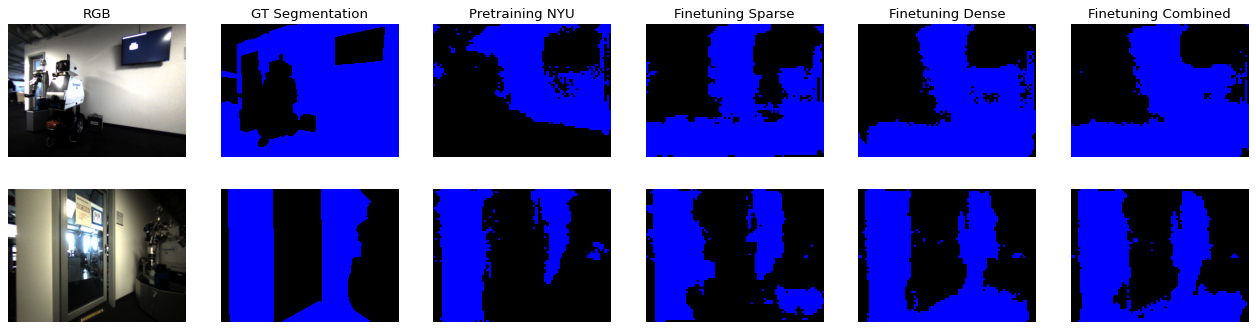

In [57]:
## On Office GT: best: 24, (8, 15, 17)

samples_iter1 = iter(val_ds_office_gt)
samples_iter2 = iter(val_ds_office_gt)
entries = list()
"""
index = 25
for i in range(index):
    entry = next(samples_iter1)
    if i > index - 5:
        entries.append(entry)
"""
for i in range(17):
    entry1 = next(samples_iter1)
for i in range(24):
    entry2 = next(samples_iter2)
entries.append(entry1)
entries.append(entry2)

i = 0    
rows = len(entries)
figure0 = plt.figure(figsize=(20, 5), dpi=80)
for entry in entries:
    # RGB
    ax1 = plt.subplot(rows,6,i+1)
    ax1.imshow(entry['image'])
    if i == 0:
        ax1.set_title('RGB')
    plt.axis('off')
    # GT Segmentation
    ax1 = plt.subplot(rows,6,i+2)
    plt.axis('off')
    ax1.imshow(entry['label'], cmap=cmap2)
    if i == 0:
        ax1.set_title('GT Segmentation')
    # Pretrained Segmentation
    ax1 = plt.subplot(rows,6,i+3)
    plt.axis('off')
    a = tf.image.convert_image_dtype(tf.expand_dims(entry['image'],axis=0), tf.float32)
    b = pretraining_model(a)
    pred = tf.argmax(b[1], axis=-1)
    ax1.imshow(pred[0,:,:], cmap=cmap2)
    if i == 0:
        ax1.set_title('Pretraining NYU')
    # Sparse Segmentation
    ax1 = plt.subplot(rows,6,i+4)
    plt.axis('off')
    a = tf.image.convert_image_dtype(tf.expand_dims(entry['image'],axis=0), tf.float32)
    b = sparse_model(a)
    pred = tf.argmax(b[1], axis=-1)
    ax1.imshow(pred[0,:,:], cmap=cmap2)
    if i == 0:
        ax1.set_title('Finetuning Sparse')
    # Dense Segmentation
    ax1 = plt.subplot(rows,6,i+5)
    plt.axis('off')
    a = tf.image.convert_image_dtype(tf.expand_dims(entry['image'],axis=0), tf.float32)
    b = dense_model(a)
    pred = tf.argmax(b[1], axis=-1)
    ax1.imshow(pred[0,:,:], cmap=cmap2)
    if i == 0:
        ax1.set_title('Finetuning Dense')
    # Combined Segmentation
    ax1 = plt.subplot(rows,6,i+6)
    plt.axis('off')
    a = tf.image.convert_image_dtype(tf.expand_dims(entry['image'],axis=0), tf.float32)
    b = combined_model(a)
    pred = tf.argmax(b[1], axis=-1)
    ax1.imshow(pred[0,:,:], cmap=cmap2)
    if i == 0:
        ax1.set_title('Finetuning Combined')
    i = i+6

figure0.savefig("presentation_figures/visual_results_fastscnn_gt_1.pdf", bbox_inches='tight')
figure0.savefig("presentation_figures/visual_results_fastscnn_gt_1.png", bbox_inches='tight')

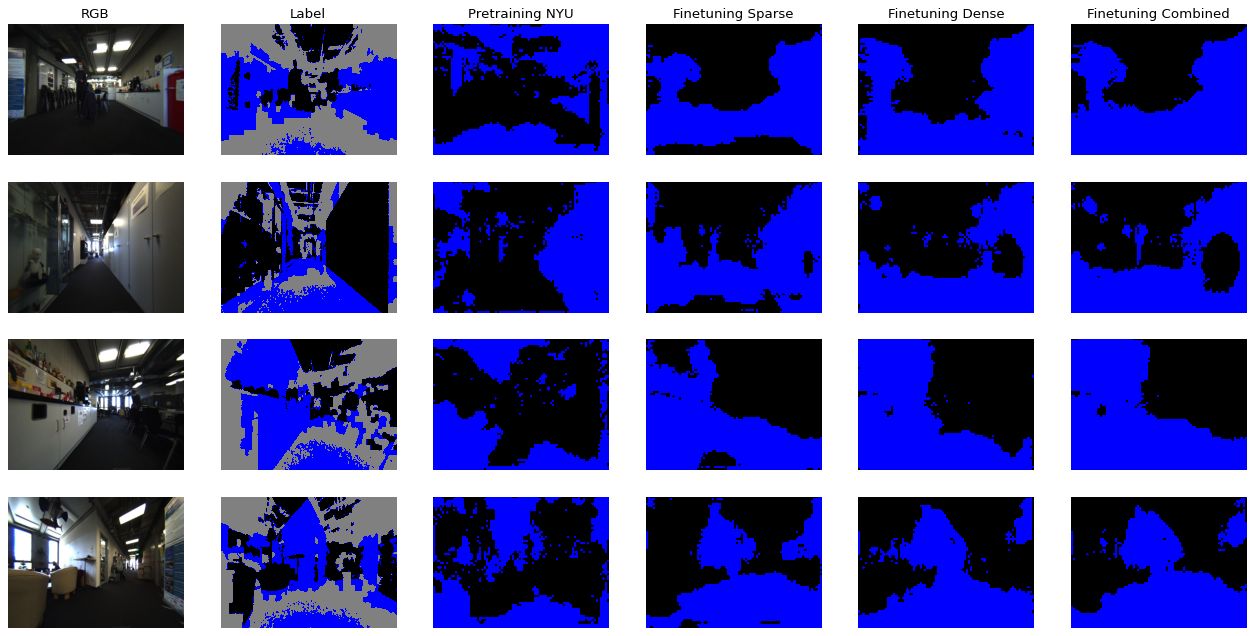

In [69]:
def preprocess_bagfile(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize image and label.
    image = tf.image.resize(image, (480, 640),
                          method=tf.image.ResizeMethod.BILINEAR)
    label = tf.image.resize(label, (480, 640),
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # Mask out unknown pixels.
    mask = tf.squeeze(tf.not_equal(label, 2))
    label = tf.cast(label, tf.uint8)
    image = tf.cast(image, tf.float32)
    return image, label, mask 

## On Office 12

samples_iter1 = iter(val_ds_office_3)
samples_iter2 = iter(val_ds_office_3)
entries = list()

index = 10
for i in range(index):
    entry = next(samples_iter1)
    if i > index - 5:
        entries.append(entry)
"""
for i in range(4):
    entry1 = next(samples_iter1)
for i in range(5):
    entry2 = next(samples_iter2)
entries.append(entry1)
entries.append(entry2)
"""

i = 0    
rows = len(entries)
figure0 = plt.figure(figsize=(20, 10), dpi=80)    

for entry in entries:
    image, label, mask = preprocess_bagfile(entry['image'], entry['label'])
    # RGB
    ax1 = plt.subplot(rows,6,i+1)
    ax1.imshow(image)
    if i == 0:
        ax1.set_title('RGB')
    plt.axis('off')
    # Label
    ax1 = plt.subplot(rows,6,i+2)
    plt.axis('off')
    ax1.imshow(label, cmap=cmap3)
    if i == 0:
        ax1.set_title('Label')
    # Pretrained Segmentation
    ax1 = plt.subplot(rows,6,i+3)
    plt.axis('off')
    a = tf.image.convert_image_dtype(tf.expand_dims(image,axis=0), tf.float32)
    b = pretraining_model(a)
    pred = tf.argmax(b[1], axis=-1)
    ax1.imshow(pred[0,:,:], cmap=cmap2)
    if i == 0:
        ax1.set_title('Pretraining NYU')
    # Sparse Segmentation
    ax1 = plt.subplot(rows,6,i+4)
    plt.axis('off')
    a = tf.image.convert_image_dtype(tf.expand_dims(image,axis=0), tf.float32)
    b = sparse_model(a)
    pred = tf.argmax(b[1], axis=-1)
    ax1.imshow(pred[0,:,:], cmap=cmap2)
    if i == 0:
        ax1.set_title('Finetuning Sparse')
    # Dense Segmentation
    ax1 = plt.subplot(rows,6,i+5)
    plt.axis('off')
    a = tf.image.convert_image_dtype(tf.expand_dims(image,axis=0), tf.float32)
    b = dense_model(a)
    pred = tf.argmax(b[1], axis=-1)
    ax1.imshow(pred[0,:,:], cmap=cmap2)
    if i == 0:
        ax1.set_title('Finetuning Dense')
    # Combined Segmentation
    ax1 = plt.subplot(rows,6,i+6)
    plt.axis('off')
    a = tf.image.convert_image_dtype(tf.expand_dims(image,axis=0), tf.float32)
    b = combined_model(a)
    pred = tf.argmax(b[1], axis=-1)
    ax1.imshow(pred[0,:,:], cmap=cmap2)
    if i == 0:
        ax1.set_title('Finetuning Combined')
    i += 6
figure0.savefig("presentation_figures/visual_results_fastscnn_office12_1.pdf", bbox_inches='tight')
figure0.savefig("presentation_figures/visual_results_fastscnn_office12_1.png", bbox_inches='tight')

## visual_results_fastscnn+depth_nyu1 (rgb, gt_seg, pred_seg, gt_depth, pred_depth)

In [6]:
from scipy import stats
def ignorant_depth_loss(depth_label, y_pred_depth, maxDepthVal=1000.0 / 10.0): 
    """
    wrapper to mask all "NaN" values in depth
    """
    y_pred_depth_ignorant = tf.where(tf.math.is_nan(depth_label),
                                     tf.zeros_like(depth_label), y_pred_depth)
    depth_label = tf.where(tf.math.is_nan(depth_label),
                           tf.zeros_like(depth_label), depth_label)
    #print("Ignorant depth loss: ")
    #print("depth_label: {}".format(depth_label))
    #print("y_pred_depth_ignorant: {}".format(y_pred_depth_ignorant))

    return depth_loss_function(depth_label, y_pred_depth_ignorant, maxDepthVal=maxDepthVal)


def depth_loss_function(y_true, y_pred, theta=0.1, maxDepthVal=1000.0 / 10.0): 
    """ Loss Function from DenseDepth paper.
      Code taken from here https://github.com/ialhashim/DenseDepth/blob/master/loss.py
    """

    # Point-wise depth
    l_depth = tf.keras.backend.mean(tf.keras.backend.abs(y_pred - y_true),
                                    axis=-1)
    # Edges
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = tf.keras.backend.mean(tf.keras.backend.abs(dy_pred - dy_true) +
                                    tf.keras.backend.abs(dx_pred - dx_true),
                                    axis=-1)

    # Structural similarity (SSIM) index
    l_ssim = tf.keras.backend.clip(
        (1 - tf.image.ssim(y_true, y_pred, maxDepthVal)) * 0.5, 0, 1)

    # Weights
    w1 = 1.0
    w2 = 1.0
    w3 = theta

    return (w1 * l_ssim) + (w2 * tf.keras.backend.mean(l_edges)) + (
        w3 * tf.keras.backend.mean(l_depth))

def tf_boxcox(input):
    y = tf.numpy_function(stats.boxcox, [input], (tf.float32, tf.float64))
    return y 

def ignorant_standardization(x):
    valid_pixels = tf.where(tf.math.is_nan(x), 
                            tf.constant(0, dtype=tf.float32), tf.constant(1, dtype=tf.float32))
    num_pixels = tf.reduce_sum(valid_pixels)
    nan_mask = tf.math.logical_not(tf.math.is_nan(x))
    x_nonans = tf.boolean_mask(x, nan_mask)
    nanmean = tf.math.reduce_mean(x_nonans)
    nanstd = tf.math.reduce_std(x_nonans)
    min_nanstd = tf.math.rsqrt(num_pixels)
    adjusted_nanstd = tf.math.maximum(min_nanstd, nanstd)
    x_standardized = x - nanmean
    x_standardized = tf.math.divide(x_standardized, adjusted_nanstd)
    return x_standardized, nanmean, adjusted_nanstd

def preprocess_boxcox_standardize(depth_label_orig):
    depth_label = tf.expand_dims(depth_label_orig, -1)
    depth_norm_2 = tf.where(
        tf.equal(depth_label, tf.constant(0, dtype=tf.float32)),
        tf.constant(float('nan'), dtype=tf.float32), depth_label)
    #depth_norm_2 = 10 / depth_norm_2
    
    # boxcox in 1D
    old_shape = depth_norm_2.shape
    depth_flattened = tf.reshape(depth_norm_2, [-1])
    depth_flattened_trans, boxcox_lambda  = tf_boxcox(depth_flattened)
    depth_restored = tf.reshape(depth_flattened_trans, old_shape)
    
    # standardize
    depth_standardized = tf.image.per_image_standardization(depth_restored)
    return depth_standardized, boxcox_lambda

def preprocess_inverse_median(depth_label):
    # clip max depth value to 10
    depth_label = tf.where(
          tf.math.greater_equal(depth_label, tf.constant(10, dtype=tf.float32)),
          tf.constant(float(10), dtype=tf.float32), depth_label)
    # clip min depth value to 0.5
    depth_label = tf.where(
        tf.less(depth_label, tf.constant(0.5, dtype=tf.float32)),
        tf.constant(float(0.5), dtype=tf.float32), depth_label)
    # replace zeros with NaN for depth
    depth_norm_2 = tf.where(
          tf.equal(depth_label, tf.constant(0, dtype=tf.float32)),
          tf.constant(float('nan'), dtype=tf.float32), depth_label)
    # normalize depth (inverse + median (4.03) scaling)
    depth_norm_2 = 10 / depth_norm_2 - 4.03 
    return depth_norm_2

def preprocess_power_median(depth_label):
    # clip max depth value to 10
    depth_label = tf.where(
          tf.math.greater_equal(depth_label, tf.constant(10, dtype=tf.float32)),
          tf.constant(float(10), dtype=tf.float32), depth_label)
    # clip min depth value to 0.5
    depth_label = tf.where(
        tf.less(depth_label, tf.constant(0.5, dtype=tf.float32)),
        tf.constant(float(0.5), dtype=tf.float32), depth_label)

    # replace zeros with NaN for depth
    depth_norm_2 = tf.where(
          tf.equal(depth_label, tf.constant(0, dtype=tf.float32)),
          tf.constant(float('nan'), dtype=tf.float32), depth_label)
    # normalize depth (power (lambda = 0.54) + median (1.29) scaling)
    depth_norm_2 = (depth_norm_2**0.54 - 1)/0.54 - 1.29
    return depth_norm_2

def preprocess_power_standardize(depth_label):
    # clip max depth value to 10
    depth_label = tf.where(
          tf.math.greater_equal(depth_label, tf.constant(10, dtype=tf.float32)),
          tf.constant(float(10), dtype=tf.float32), depth_label)
    # clip min depth value to 0.5
    depth_label = tf.where(
        tf.less(depth_label, tf.constant(0.5, dtype=tf.float32)),
        tf.constant(float(0.5), dtype=tf.float32), depth_label)

    # replace zeros with NaN for depth
    depth_norm_2 = tf.where(
          tf.equal(depth_label, tf.constant(0, dtype=tf.float32)),
          tf.constant(float('nan'), dtype=tf.float32), depth_label)
    # normalize depth (power (lambda = 0.54) + median (1.29) scaling)
    depth_norm_2 = (depth_norm_2**0.54 - 1)/0.54
    depth_standardized, _, _ = ignorant_standardization(depth_norm_2)
    return depth_standardized

def preprocess_inverse_standardize(depth_label_orig):
    depth_label = tf.expand_dims(depth_label_orig, -1)
    depth_norm_2 = tf.where(
        tf.equal(depth_label, tf.constant(0, dtype=tf.float32)),
        tf.constant(float('nan'), dtype=tf.float32), depth_label)
    depth_norm_2 = 10 / depth_norm_2
    depth_standardized = tf.image.per_image_standardization(depth_norm_2)
    return depth_standardized

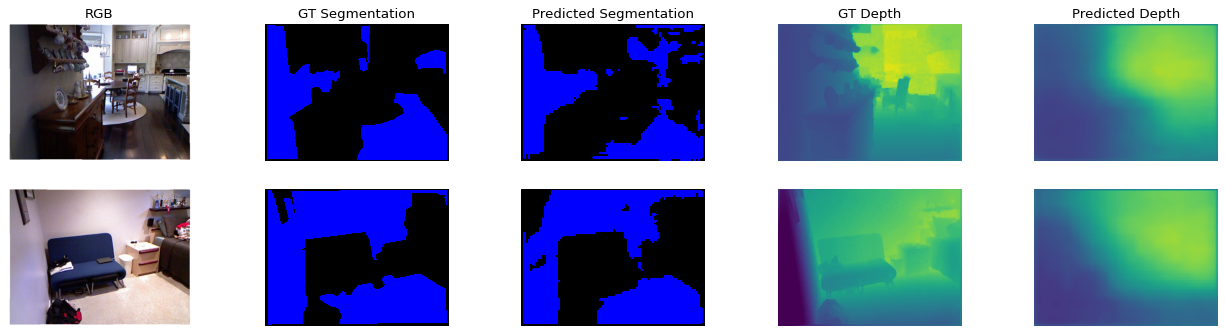

In [23]:
# Power + standardize
samples_iter1 = iter(nyu_depth_ds)
samples_iter2 = iter(nyu_depth_ds)
entries = list()
"""
index = 25
for i in range(index):
    entry = next(samples_iter1)
    if i > index - 5:
        entries.append(entry)
"""
for i in range(1):
    entry1 = next(samples_iter1)
for i in range(2):
    entry2 = next(samples_iter2)
entries.append(entry1)
entries.append(entry2)

i = 0    
rows = len(entries)
figure0 = plt.figure(figsize=(20, 5), dpi=80) 
 
model0 = tf.keras.models.load_model('/home/matthias/data/rss_2021_data/xavier_models/nyu_depth_pretraining_14/model_epoch_65.h5', custom_objects={'tf': tf})
for entry in entries:
    # RGB
    ax1 = plt.subplot(rows,5,i+1)
    plt.axis('off')
    ax1.imshow(entry['image'])
    if i == 0:
        ax1.set_title('RGB')
    # GT Semseg
    ax1 = plt.subplot(rows,5,i+2)
    plt.axis('off')
    ax1.imshow(entry['label']['seg'], cmap=cmap2)
    if i == 0:
        ax1.set_title('GT Segmentation')
    # Pred Semseg
    ax1 = plt.subplot(rows,5,i+3)
    plt.axis('off')
    a = tf.image.convert_image_dtype(tf.expand_dims(entry['image'],axis=0), tf.float32)
    b = model0(a)[1]
    semseg = b[0]
    pred = tf.argmax(semseg, axis=-1)
    ax1.imshow(pred[0,:,:], cmap=cmap2)
    if i == 0:
        ax1.set_title('Predicted Segmentation')
    # Depth label
    ax1 = plt.subplot(rows,5,i+4)
    plt.axis('off')
    depth_label_orig = entry['label']['distance']
    depth_label_preproc = preprocess_power_standardize(depth_label_orig)
    plot1 = ax1.imshow(depth_label_preproc, vmin=-2, vmax=2)
    #plt.colorbar(plot1,ax=ax1)
    label_depth = tf.expand_dims(depth_label_preproc,0)
    if i == 0:
        ax1.set_title('GT Depth')
    
    # Depth predictions
    ax1 = plt.subplot(rows,5,i+5)
    plt.axis('off')
    depth = b[2]
    plot1 = ax1.imshow(depth[0,:,:], vmin=-2, vmax=2)
    #plt.colorbar(plot1,ax=ax1)
    pred_depth = tf.expand_dims(depth[0,:,:],0)
    if i == 0:
        ax1.set_title('Predicted Depth')
    
    i+=5
    
figure0.savefig("presentation_figures/visual_results_fastscnn+depth_nyu_1.pdf", bbox_inches='tight')
figure0.savefig("presentation_figures/visual_results_fastscnn+depth_nyu_1.png", bbox_inches='tight')

## visual_results_fastscnn+depth_1 (rbg, gt_seg, pred_seg_pre, pred_seg, pred_depth_pre, pred_depth)

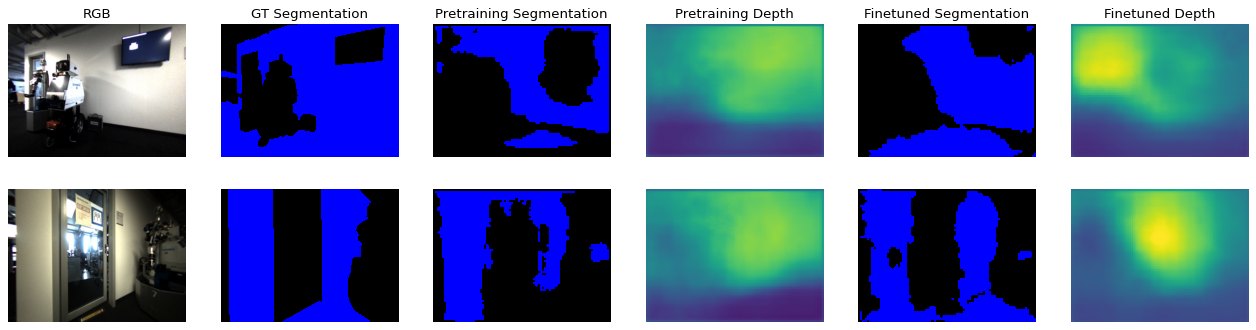

In [19]:
# Power + standardize
samples_iter1 = iter(val_ds_office_gt)
samples_iter2 = iter(val_ds_office_gt)
entries = list()
"""
index = 25
for i in range(index):
    entry = next(samples_iter1)
    if i > index - 5:
        entries.append(entry)
"""
for i in range(17):
    entry1 = next(samples_iter1)
for i in range(24):
    entry2 = next(samples_iter2)
entries.append(entry1)
entries.append(entry2)

i = 0    
rows = len(entries)
figure0 = plt.figure(figsize=(20, 5), dpi=80) 
model_pre = tf.keras.models.load_model('/home/matthias/data/rss_2021_data/xavier_models/nyu_depth_pretraining_14/model_epoch_65.h5', custom_objects={'tf': tf}) 
model_fine = tf.keras.models.load_model('/home/matthias/data/rss_2021_data/xavier_models/office3_densedepth20_dyn_cam2_finetuning_2/model_epoch_6.h5', custom_objects={'tf': tf})
for entry in entries:
    # RGB
    ax1 = plt.subplot(rows,6,i+1)
    plt.axis('off')
    ax1.imshow(entry['image'])
    if i == 0:
        ax1.set_title('RGB')
    # GT Semseg
    ax1 = plt.subplot(rows,6,i+2)
    plt.axis('off')
    ax1.imshow(entry['label'], cmap=cmap2)
    if i == 0:
        ax1.set_title('GT Segmentation')
    # Pred Semseg Pre
    ax1 = plt.subplot(rows,6,i+3)
    plt.axis('off')
    a = tf.image.convert_image_dtype(tf.expand_dims(entry['image'],axis=0), tf.float32)
    b = model_pre(a)[1]
    semseg = b[0]
    pred = tf.argmax(semseg, axis=-1)
    ax1.imshow(pred[0,:,:], cmap=cmap2)
    if i == 0:
        ax1.set_title('Pretraining Segmentation')    
    # Depth predictions Pre
    ax1 = plt.subplot(rows,6,i+4)
    plt.axis('off')
    depth = b[2]
    plot1 = ax1.imshow(depth[0,:,:], vmin=-2, vmax=2)
    #plt.colorbar(plot1,ax=ax1)
    pred_depth = tf.expand_dims(depth[0,:,:],0)
    if i == 0:
        ax1.set_title('Pretraining Depth')
    # Pred Semseg Fine
    ax1 = plt.subplot(rows,6,i+5)
    plt.axis('off')
    a = tf.image.convert_image_dtype(tf.expand_dims(entry['image'],axis=0), tf.float32)
    b = model_fine(a)[1]
    semseg = b[0]
    pred = tf.argmax(semseg, axis=-1)
    ax1.imshow(pred[0,:,:], cmap=cmap2)
    if i == 0:
        ax1.set_title('Finetuned Segmentation')    
    # Depth predictions Fine
    ax1 = plt.subplot(rows,6,i+6)
    plt.axis('off')
    depth = b[2]
    plot1 = ax1.imshow(depth[0,:,:], vmin=-2, vmax=2)
    #plt.colorbar(plot1,ax=ax1)
    pred_depth = tf.expand_dims(depth[0,:,:],0)
    if i == 0:
        ax1.set_title('Finetuned Depth')
    
    i+=6
    
figure0.savefig("presentation_figures/visual_results_fastscnn+depth_officegt_1.pdf", bbox_inches='tight')
figure0.savefig("presentation_figures/visual_results_fastscnn+depth_officegt_1.png", bbox_inches='tight')

## garage_depth_labels

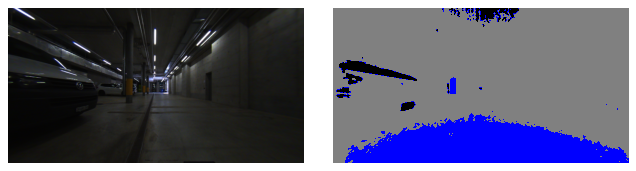

In [33]:
image = plt.imread('/home/matthias/data/rss_2021_data/label_datasets/garage1_visualization/1621518579.405964_rgb.png')
label = plt.imread('/home/matthias/data/rss_2021_data/label_datasets/garage1_visualization/1621518579.405964_labels.png')
figure0 = plt.figure(figsize=(10, 5), dpi=80)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.subplot(1,2,1)
plt.imshow(image)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(label, cmap=cmap3)
plt.axis('off')

figure0.savefig("presentation_figures/garage_depth_labels.pdf", bbox_inches='tight')
figure0.savefig("presentation_figures/garage_depth_labels.png", bbox_inches='tight')

# Median Scaling Tests

In [16]:
nyu_depth_ds_complete = tfds.load("NyuDepthV2LabeledDepth", split="full")

In [44]:
summed_median = 0
summed_mean = 0
summed_std = 0
summed_blambda = 0
print(len(nyu_depth_ds_complete))
for entry in nyu_depth_ds_complete:
    depth_label_orig = entry['label']['distance']
    ## preprocess nyu depth
    depth_label = tf.expand_dims(depth_label_orig, -1)
    depth_norm_2 = tf.where(
        tf.equal(depth_label, tf.constant(0, dtype=tf.float32)),
        tf.constant(float('nan'), dtype=tf.float32), depth_label)
    depth_norm_2 = tf.where(
        tf.less(depth_norm_2, tf.constant(0.5, dtype=tf.float32)),
        tf.constant(float(0.5), dtype=tf.float32), depth_norm_2)
    depth_norm_2 = 10 / depth_norm_2 - 4.03 # inverse + median scaling
    # depth_norm_2 = (depth_norm_2**0.54 - 1)/0.54 - 1.29 # boxcox + median scaling
    blambda = 0 # dummy
    # test, blambda = preprocess_boxcox_standardize(depth_norm_2)
    median = np.nanmedian(depth_norm_2)
    mean = np.nanmean(depth_norm_2)
    std = np.nanstd(depth_norm_2)
    summed_median += median
    summed_mean += mean
    summed_std += std
    summed_blambda += blambda
    #plt.imshow(np.squeeze(depth_norm_2))
    #plt.colorbar()
    #break
final_blambda = summed_blambda / len(nyu_depth_ds_complete)
final_median = summed_median / len(nyu_depth_ds_complete)
final_mean = summed_mean / len(nyu_depth_ds_complete)
final_std = summed_std / len(nyu_depth_ds_complete)
print("Median: {}".format(final_median))
print("Mean: {}".format(final_mean))
print("Std: {}".format(final_std)) 
print("Average Boxcox lambda: {}".format(final_blambda)) # 0.5397 (non-inverse, of course)

1449
Median: 0.0045489989287940446
Mean: 0.44285951700250203
Std: 1.6549379966890836
Average Boxcox lambda: 0.0


In [75]:
val_ds_office_3_depth = tfds.load('MeshdistPseudolabelsDenseDepth', split='office3_densedepth20_dyn_cam2')

In [43]:
summed_median = 0
summed_mean = 0
summed_std = 0
summed_blambda = 0
print(len(val_ds_office_3))
for entry in val_ds_office_3_depth:
    depth_label_orig = entry['label']['distance']
    ## preprocess nyu depth
    depth_label = tf.expand_dims(depth_label_orig, -1)
    depth_label = tf.cast(depth_label, tf.float32) * 10 / 255
    depth_norm_2 = tf.where(
        tf.equal(depth_label, tf.constant(0, dtype=tf.float32)),
        tf.constant(float('nan'), dtype=tf.float32), depth_label)
    depth_norm_2 = tf.where(
        tf.less(depth_norm_2, tf.constant(0.5, dtype=tf.float32)),
        tf.constant(float(0.5), dtype=tf.float32), depth_norm_2)
    depth_norm_2 = 10 / depth_norm_2 - 4.03 # inverse + median scaling
    #depth_norm_2 = (depth_norm_2**0.54 - 1)/0.54 - 1.29 # boxcox + median scaling
    blambda = 0 # dummy
    #test, blambda = preprocess_boxcox_standardize(depth_norm_2)
    median = np.nanmedian(depth_norm_2)
    mean = np.nanmean(depth_norm_2)
    std = np.nanstd(depth_norm_2)
    summed_median += median
    summed_mean += mean
    summed_std += std
    summed_blambda += blambda
    #plt.imshow(np.squeeze(depth_norm_2))
    #plt.colorbar()
    #break
final_blambda = summed_blambda / len(nyu_depth_ds_complete)
final_median = summed_median / len(val_ds_office_3)
final_mean = summed_mean / len(val_ds_office_3)
final_std = summed_std / len(val_ds_office_3)
print("Median: {}".format(final_median))
print("Mean: {}".format(final_mean))
print("Std: {}".format(final_std))
print("Average Boxcox lambda: {}".format(final_blambda)) # 4.86 (non-inverse, of course)


831
Median: 2.4958424593997774
Mean: 3.0119908876430186
Std: 3.234270401379692
Average Boxcox lambda: 0.0


# DORN Test

10.0
0.0
(1, 1, 400, 760)
(1, 80, 400, 760)
(1, 80, 400, 760)
(1, 400, 760)
(1, 1, 400, 760)


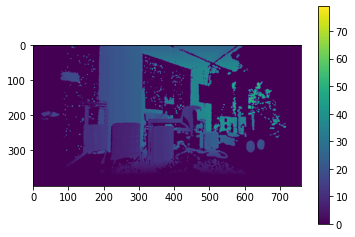

In [117]:
def create_ord_label(depth):
    ord_num = 80
    beta = 10
    discretization = "SID"
    N, _, H, W = depth.shape
    ord_c0 = tf.ones([N, ord_num, H, W])
    
    if discretization == "SID":
        label = ord_num * tf.math.log(depth) / np.log(beta)
    else:
        label = ord_num * (depth - 1.0) / (beta - 1.0)
    label = tf.cast(label, dtype=tf.int64)
    mask = tf.linspace(0, 79, ord_num) # ord_num - 1 instead of 255
    mask = tf.expand_dims(mask, 0)
    mask = tf.expand_dims(mask, -1)
    mask = tf.expand_dims(mask, -1)
    mask = tf.tile(mask, [N, 1, H, W])
    mask = tf.cast(mask, tf.int64)
    print(mask.shape)
    print(ord_c0.shape)
    
    mask = tf.equal(mask, label)
    ord_c0 = tf.where(mask, 0, ord_c0) #ord_c0[mask] = 0
    ord_c1 = 1 - ord_c0
    return ord_c0, ord_c1

for entry in val_ds_office_3_depth:
    test_depth = tf.cast(entry['label']['distance'], tf.float32) *10/255
    print(np.max(test_depth))
    print(np.min(test_depth))
    test_depth2 = tf.expand_dims(tf.squeeze(test_depth), 0)
    test_depth2 = tf.expand_dims(test_depth2, 0)
    print(test_depth2.shape)
    ord_c0, ord_c1 = create_ord_label(test_depth2)
    final_depth = tf.math.argmax(ord_c1, axis=1)
    print(final_depth.shape)
    final_depth = tf.squeeze(final_depth)
    break
plt.imshow(final_depth)
print(test_depth2.shape)
plt.colorbar()

